In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px 
import pandas as pd

from axion_functions import *

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy
me_hca = (const.m_e/((const.hbar/(const.c*unit.AA)).si)).value #Electron mass, in units of... hbar/(c*AA) to cancel with |G| (LMAOOOOO)
me_hca

# Define unknown constants
#g_ag = 2e-10 #Axion-photon coupling (Primakoff process), in GeV^(-1).
#Upper bound on g_ag of 2.7e-10 from the Sun, see Di Luzio's review
#lmda = (g_ag/(1e-8))**4
phi_0 = 5.95e14 #in cm^(-2) s^(-1)
E_0    = 1.103 #in keV

#Crystal Geometry
diam = 110*unit.mm
hgt = 250*unit.mm 
#vol = ((np.pi*(diam/2)**2*hgt).to(unit.AA**3)).value #Crystal volume, in AA^3
vol = ((50*unit.kg/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value
#Make volume make the mass like 7kg
vol_cell = 67.71 #In AA^3, from Dent paper

In [30]:
def complete_dndt(max_hkl = 5, print_output = False, all_even = False, k=[1,0,0], abs_forgot = True, coupling=2e-10):
    if not all_even:
        hkl = np.array(make_hkl_s(max_h = max_hkl, 
                                max_k = max_hkl,
                                max_l = max_hkl))
    else:
        hkl = np.array(make_hkl(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl, s=True))
        
    g_ag = coupling

    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)

    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq = FA_q(mod2_g)

    ginv_array = 1/mod2_g

    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)

    ghat = g_arr*np.sqrt(ginv_replicant)

    if abs_forgot:
        gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k))))
    else:
        gk = gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k)))

    sin2 = 4*gk**2*(1-gk**2) #Only dependence on k

    summand = FAq*ginv_array*sin2*4 #Use *4 if implementing s

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV #I lied this depends on k as well
    #The infinities here are fine; they go to zero in the W function

    W = w_func(E_arr, E1=1, E2=10, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
     
    #W = w_func(E_arr, E1=1, E2=50, dVector=False, Delta = 1) #Delta from Simulation of BG report
    dphi_de = make_dpde(E_arr, coupling=g_ag)
    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    #Conversion factor of angstroms to cm missing somewhere
    #Absorption also looks like it's a huge deal (order -9 or so)
    final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
    if print_output:
        print("dN/dt = {:.3e} s^(-1)".format(final_dndt))
    return (final_dndt*(unit.s**(-1))*(3*unit.year)).si

In [62]:
phi_axis =  np.arange(0, 2*np.pi, 0.05)
theta_axis = np.arange(0,np.pi, 0.05)
angle_plane = np.array(list(itertools.product(phi_axis, theta_axis)))

def angle_dependence(g_ag = 2e-10):
    outputs = []
    for angles in angle_plane:
        phi = angles[0]
        theta = angles[1]
        k_vec = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
        outputs.append(complete_dndt(k = k_vec, abs_forgot = True, all_even=False, coupling = g_ag))
    return np.array(outputs)

rates_on_angle = angle_dependence()

C:\Users\taase\AppData\Local\Temp\ipykernel_23516\505354353.py:33: RuntimeWarning:

divide by zero encountered in divide

c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:104: RuntimeWarning:

overflow encountered in exp



In [63]:
dict = {"phi"  : angle_plane[:,0],
        "theta": angle_plane[:,1],
        "rate" : rates_on_angle}
df = pd.DataFrame(dict)

fig = px.scatter_3d(
    x = np.sin(df["theta"])*np.cos(df["phi"]),
    y = np.sin(df["theta"])*np.sin(df["phi"]),
    z = np.cos(df["theta"]),
    color=df["rate"], color_continuous_scale="Hot"
)
fig.show()

In [64]:
rates_square = np.reshape(rates_on_angle, (len(phi_axis), len(theta_axis)))

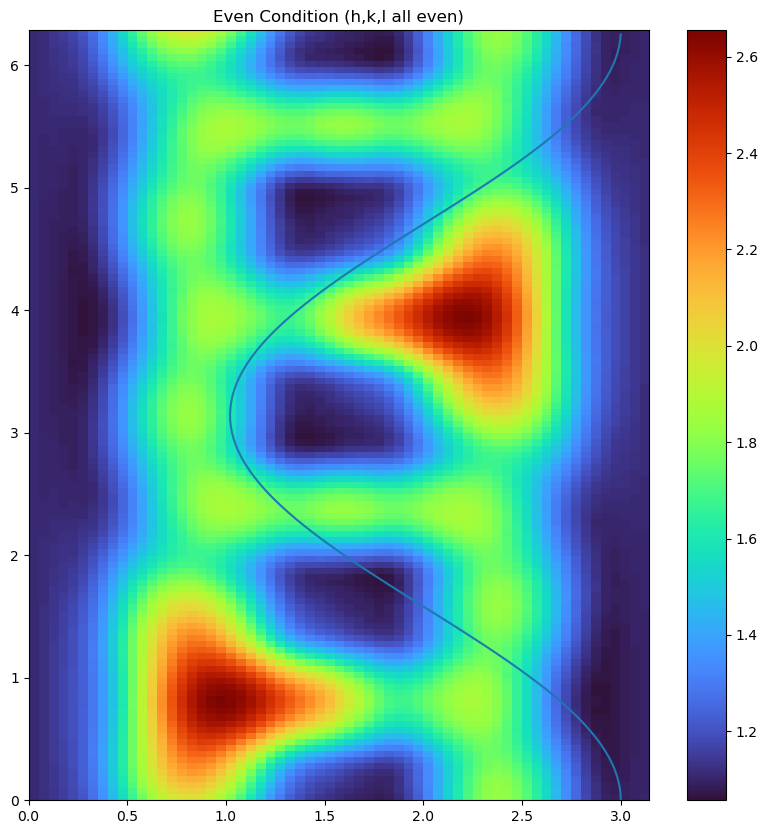

In [65]:
theta_phi = lambda x: (np.pi/2)+0.99*np.cos(x)+0.44

fig,ax = plt.subplots(figsize=(10,10))
image = ax.imshow(rates_square, interpolation='none', extent = (0,np.pi,0,2*np.pi), aspect='auto', origin='lower', cmap='turbo')
path = ax.plot(theta_phi(phi_axis), phi_axis)
plt.colorbar(image)
plt.title("Even Condition (h,k,l all even)")
plt.show()

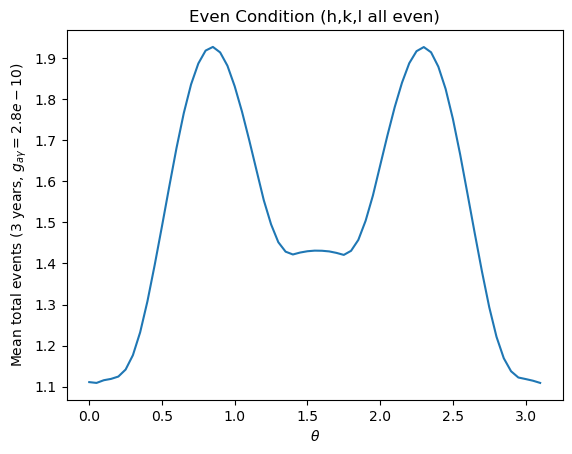

In [66]:
phi_sum = np.mean(rates_square, axis=0)

plt.plot(theta_axis, phi_sum)
plt.xlabel("$\\theta$")
plt.ylabel("Mean total events (3 years, $g_{a\\gamma} = 2.8e-10$)")
plt.title("Even Condition (h,k,l all even)")
plt.show()

In [67]:
def k_from_polar(theta,phi):
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def line_integral(theta_func, phi):
    dphi = np.diff(phi)
    integral = 0
    for index in range(len(phi)-1):
        p = phi[index]
        k_vec = k_from_polar(theta_func(p), p)
        integral += complete_dndt(all_even = False, k=k_vec)*dphi[index]
    return integral

In [68]:
def theta_funcd(theta_func, phi):
    output = []
    for p in phi:
        k_vec = k_from_polar(theta_func(p), p)
        output.append(complete_dndt(all_even = False, k=k_vec))
    return np.array(output)


C:\Users\taase\AppData\Local\Temp\ipykernel_23516\505354353.py:33: RuntimeWarning:

divide by zero encountered in divide

c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Code\axion_functions.py:104: RuntimeWarning:

overflow encountered in exp



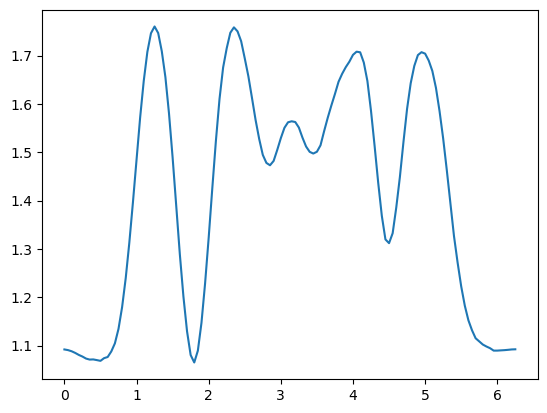

In [69]:
plt.plot(phi_axis, theta_funcd(theta_phi, phi_axis))

In [72]:
line_integral(theta_phi, phi_axis)

C:\Users\taase\AppData\Local\Temp\ipykernel_23516\505354353.py:33: RuntimeWarning:

divide by zero encountered in divide



<Quantity 8.86678538>